In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn.functional import relu, binary_cross_entropy, mse_loss
import torchvision
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage
from tqdm.notebook import tqdm
from tensorboardX import SummaryWriter
from torchinfo import summary
from PIL import Image

# Import des données CIFAR10

In [2]:
device = torch.device("cuda")
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
data_train = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
data_test = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [4]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

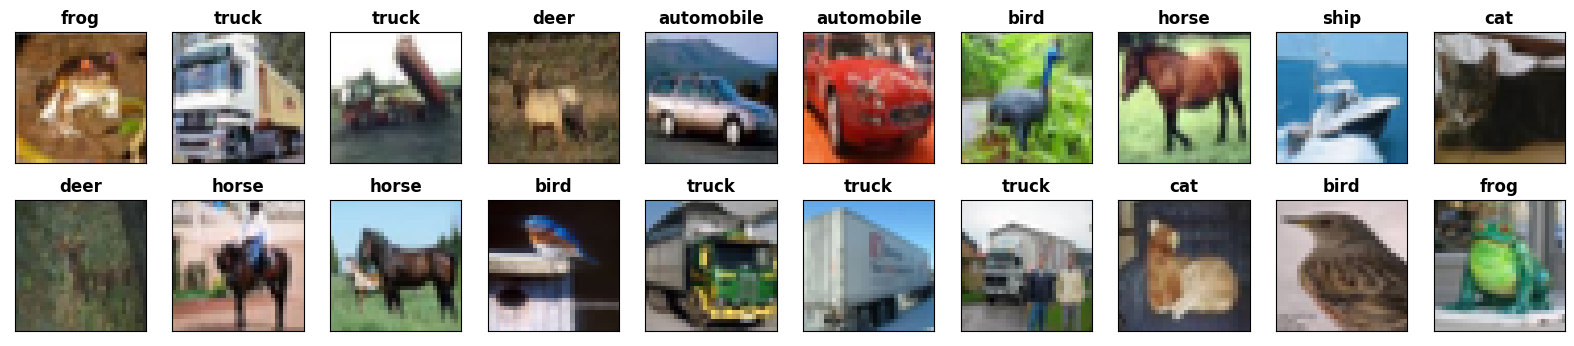

In [5]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(trainset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(trainset[i + number][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i + number][1]]}", fontweight="bold")
plt.show()

In [6]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [7]:
len(trainset)

50000

# VAE

Le générateur d'un GAN est en fait le même modèle que le décodeur d'un VAE. Je teste donc un VAE sur CIFAR pour voir la structure qui marche le mieux pour le décodeur, et reprendre la même pour mon générateur. <br>
Après tests d'implémentation en linear (i.e. sans CNN), les résultats ne sont pas bons. Je teste donc avec des layers de convolution

Pour rappel, avec le reparametrization trick, $z = \mu + \sigma \epsilon$ avec $\epsilon \sim \mathcal{N}(0, 1)$

In [8]:
class VAE(torch.nn.Module):
    def __init__(self, z_dim=512):
        """ Constructeur du VAE
            Initialise les couches du réseau et leurs paramètres
        """
        super(VAE, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 12, 4, stride=2, padding=1)           # [batch, 12, 16, 16]
        self.conv2 = torch.nn.Conv2d(12, 24, 4, stride=2, padding=1)          # [batch, 24, 8, 8]
        self.conv3 = torch.nn.Conv2d(24, 48, 4, stride=2, padding=1)          # [batch, 48, 4, 4]
        self.fc1 = torch.nn.Linear(48*4*4, z_dim)
        self.fc2 = torch.nn.Linear(48*4*4, z_dim)
        self.fc3 = torch.nn.Linear(z_dim, 48*4*4)
        self.conv4 = torch.nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1) # [batch, 24, 8, 8]
        self.conv5 = torch.nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1) # [batch, 12, 16, 16]
        self.conv6 = torch.nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)  # [batch, 3, 32, 32]
        
        
    def encode(self, x):
        """ Encode un batch d'images
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images
            Output:
                mu (tensor torch, dim(batch_size x z_dim)) : moyennes des distributions apprises
                logvar (tensor torch, dim(batch_size x z_dim)) : log de la variance des distributions apprises
        """
        h1 = relu(self.conv1(x))
        h2 = relu(self.conv2(h1))
        h3 = relu(self.conv3(h2))
        h3 = h3.view(-1, 48*4*4)
        return self.fc1(h3), self.fc2(h3)

    
    def sample(self, mu, logvar):
        """ Echantillonne un vecteur latent à partir des mu et sigma générés par l'encodeur
            Args:
                mu (tensor torch, dim(batch_size x z_dim)) : moyennes des distributions apprises
                logvar (tensor torch, dim(batch_size x z_dim)) : log de la variance des distributions apprises
            Output:
                z (tensor torch, dim(batch_size x z_dim)) : batchs de vecteurs latents
        """
        std = torch.exp(0.5*logvar) # 0.5 pour prendre la racine, exp pour neutraliser le log
        epsilon = torch.randn_like(std) # randn_like : sample from N(0,1) pour tensor de dim std
        return mu  + std * epsilon
    
    
    def decode(self, z):
        """ Génère une image à partir d'un batch de vecteurs latents
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batchs de vecteurs latents
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        h4 = relu(self.fc3(z))
        h4 = h4.view(-1, 48, 4, 4)
        h5 = relu(self.conv4(h4))
        h6 = relu(self.conv5(h5))
        return torch.sigmoid(self.conv6(h6))
    
    
    def forward(self, x):
        """ Génère un batch d'images à partir d'un batch d'images initiales
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images initiales
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
                mu (tensor torch, dim(batch_size x z_dim)) : moyennes des distributions apprises
                logvar (tensor torch, dim(batch_size x z_dim)) : log de la variance des distributions apprises
        """
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar
    
    
    def compute_loss(self, x, x_prime, mu, logvar):
        """ Calcule la fonction de perte pour une itération
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images initiales
                x_tilde (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
                mu (tensor torch, dim(batch_size x z_dim)) : moyennes des distributions apprises
                logvar (tensor torch, dim(batch_size x z_dim)) : log de la variance des distributions app
            Output:
                loss (float) : valeur de la perte
        """
        cross_entropy = binary_cross_entropy(x_prime, x, reduction='sum')
        divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return cross_entropy + divergence
        
    
    def train_model(self, data, epoch, optim):
        """ Entraîne le modèle sur un batch d'images d'entraînement
            Args:
                data (tensor torch, dim(dataset_size x 3x32x32)) : jeu complet d'images initiales (en batchs)
                epoch : nombre d'itérations à réaliser sur le jeu d'entraînement complet
        """
        losses = []
        for e in tqdm(range(epoch)):
            train_loss = 0
            for batch in data:
                x = batch[0].to(torch.device("cuda"))
                optim.zero_grad()
                x_prime, mu, logvar = self.forward(x)
                loss = self.compute_loss(x, x_prime, mu, logvar)
                train_loss += loss.item()
                loss.backward()
                optim.step()
            print(f"{datetime.now().strftime('%H:%M:%S')} : Epoch {e} - Average loss {train_loss/len(data):.0f}")
            losses.append(train_loss/len(data))
        return losses

In [9]:
vae = VAE().to(torch.device("cuda"))

In [10]:
summary(vae)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─Conv2d: 1-1                            588
├─Conv2d: 1-2                            4,632
├─Conv2d: 1-3                            18,480
├─Linear: 1-4                            393,728
├─Linear: 1-5                            393,728
├─Linear: 1-6                            393,984
├─ConvTranspose2d: 1-7                   18,456
├─ConvTranspose2d: 1-8                   4,620
├─ConvTranspose2d: 1-9                   579
Total params: 1,228,795
Trainable params: 1,228,795
Non-trainable params: 0

100 itérations

In [11]:
vae = VAE().to(torch.device("cuda"))
optim_vae = torch.optim.Adam(vae.parameters())
losses = vae.train_model(data_train, 100, optim_vae)

  0%|          | 0/100 [00:00<?, ?it/s]

23:31:54 : Epoch 0 - Average loss 62740
23:32:06 : Epoch 1 - Average loss 60129
23:32:18 : Epoch 2 - Average loss 59360
23:32:30 : Epoch 3 - Average loss 59047
23:32:40 : Epoch 4 - Average loss 58870
23:32:52 : Epoch 5 - Average loss 58766
23:33:04 : Epoch 6 - Average loss 58710
23:33:15 : Epoch 7 - Average loss 58657
23:33:27 : Epoch 8 - Average loss 58621
23:33:38 : Epoch 9 - Average loss 58590
23:33:49 : Epoch 10 - Average loss 58558
23:34:00 : Epoch 11 - Average loss 58529
23:34:11 : Epoch 12 - Average loss 58508
23:34:22 : Epoch 13 - Average loss 58487
23:34:33 : Epoch 14 - Average loss 58466
23:34:45 : Epoch 15 - Average loss 58447
23:34:56 : Epoch 16 - Average loss 58432
23:35:06 : Epoch 17 - Average loss 58420
23:35:17 : Epoch 18 - Average loss 58412
23:35:28 : Epoch 19 - Average loss 58400
23:35:39 : Epoch 20 - Average loss 58394
23:35:49 : Epoch 21 - Average loss 58387
23:36:00 : Epoch 22 - Average loss 58378
23:36:11 : Epoch 23 - Average loss 58369
23:36:22 : Epoch 24 - Aver

In [12]:
pred_train = [vae.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]
pred_test = [vae.forward(testset[i][0].to(torch.device("cuda"))) for i in range(11)]

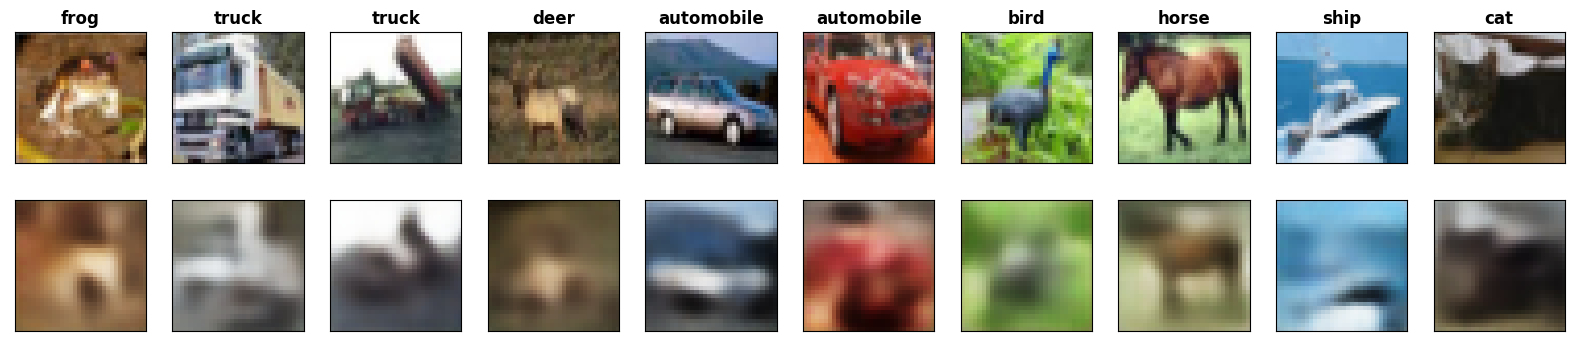

In [13]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(trainset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(pred_train[i][0].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

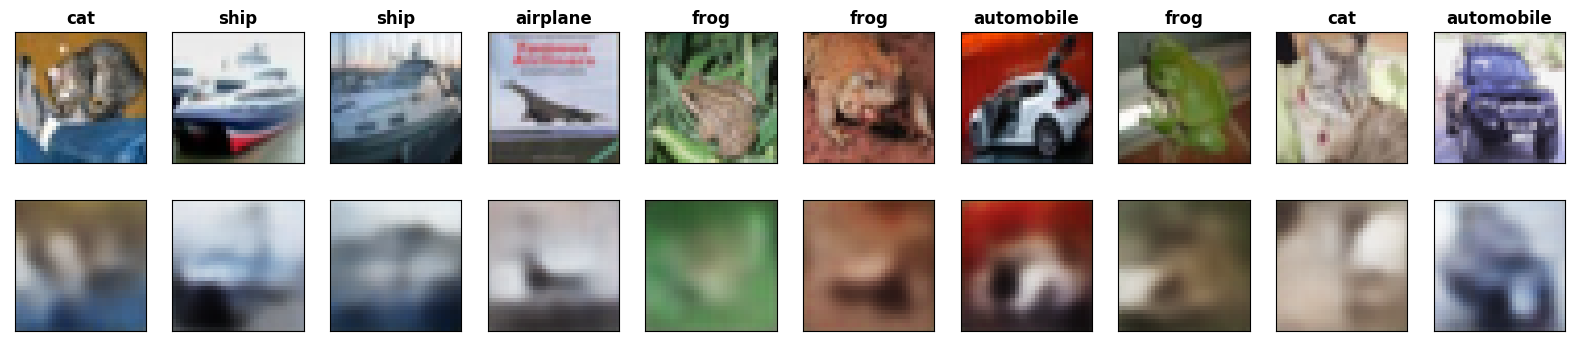

In [14]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(testset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[testset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(pred_test[i][0].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Images floues, même après 50 itérations. Test avec même archi, mais encodeur standard

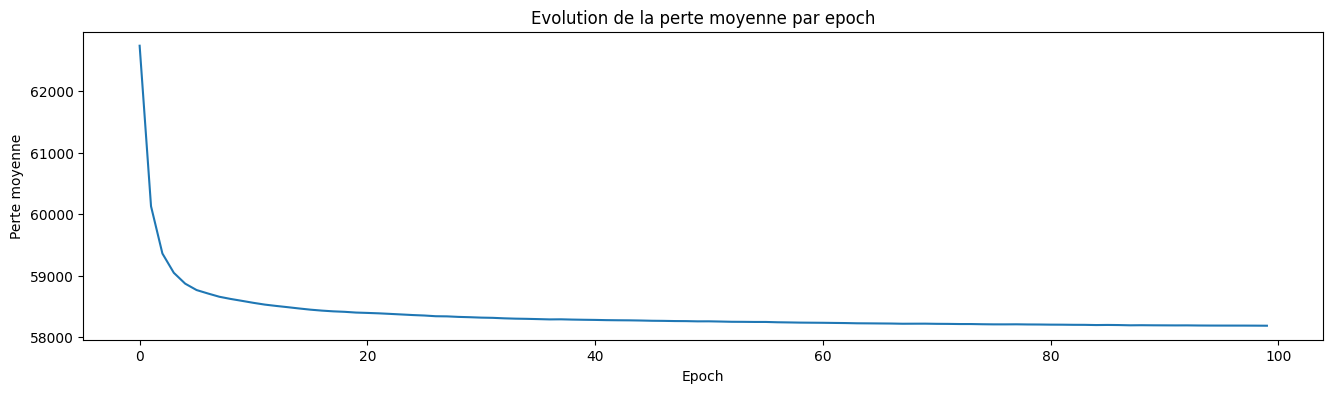

In [15]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(100), losses)
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.show()

# Autoencodeur standard

In [16]:
class Autoencodeur(torch.nn.Module):
    def __init__(self, z_dim=512):
        """ Constructeur du VAE
            Initialise les couches du réseau et leurs paramètres
        """
        super(Autoencodeur, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 12, 4, stride=2, padding=1)           # [batch, 12, 16, 16]
        self.conv2 = torch.nn.Conv2d(12, 24, 4, stride=2, padding=1)          # [batch, 24, 8, 8]
        self.conv3 = torch.nn.Conv2d(24, 48, 4, stride=2, padding=1)          # [batch, 48, 4, 4]
        self.fc1 = torch.nn.Linear(48*4*4, z_dim)
        self.fc2 = torch.nn.Linear(z_dim, 48*4*4)
        self.conv4 = torch.nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1) # [batch, 24, 8, 8]
        self.conv5 = torch.nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1) # [batch, 12, 16, 16]
        self.conv6 = torch.nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)  # [batch, 3, 32, 32]
        
        
    def encode(self, x):
        """ Encode un batch d'images
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images
            Output:
                z (tensor torch, dim(batch_size x z_dim)) : batch de vecteurs latents
        """
        h1 = relu(self.conv1(x))
        h2 = relu(self.conv2(h1))
        h3 = relu(self.conv3(h2))
        h3 = h3.view(-1, 48*4*4)
        return self.fc1(h3)
  
    
    def decode(self, z):
        """ Génère une image à partir d'un batch de vecteurs latents
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batchs de vecteurs latents
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        h4 = relu(self.fc2(z))
        h4 = h4.view(-1, 48, 4, 4)
        h5 = relu(self.conv4(h4))
        h6 = relu(self.conv5(h5))
        return torch.sigmoid(self.conv6(h6))
    
    
    def forward(self, x):
        """ Génère un batch d'images à partir d'un batch d'images initiales
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images initiales
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        z = self.encode(x)
        return self.decode(z)
    
    
    def compute_loss(self, x, x_prime):
        """ Calcule la fonction de perte pour une itération
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images initiales
                x_tilde (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
            Output:
                loss (float) : valeur de la perte
        """
        return binary_cross_entropy(x_prime, x, reduction='sum')
        
    
    def train_model(self, data, epoch, optim):
        """ Entraîne le modèle sur un batch d'images d'entraînement
            Args:
                data (tensor torch, dim(dataset_size x 3x32x32)) : jeu complet d'images initiales (en batchs)
                epoch : nombre d'itérations à réaliser sur le jeu d'entraînement complet
        """
        losses = []
        for e in tqdm(range(epoch)):
            train_loss = 0
            for batch in data:
                x = batch[0].to(torch.device("cuda"))
                optim.zero_grad()
                x_prime = self.forward(x)
                loss = self.compute_loss(x, x_prime)
                train_loss += loss.item()
                loss.backward()
                optim.step()
            print(f"{datetime.now().strftime('%H:%M:%S')} : Epoch {e} - Average loss {train_loss/len(data):.0f}")
            losses.append(train_loss/len(data))
        return losses

In [17]:
ae = Autoencodeur().to(torch.device("cuda"))
optim_ae = torch.optim.Adam(ae.parameters())
losses = ae.train_model(data_train, 100, optim_ae)

  0%|          | 0/100 [00:00<?, ?it/s]

23:50:17 : Epoch 0 - Average loss 58184
23:50:27 : Epoch 1 - Average loss 56262
23:50:37 : Epoch 2 - Average loss 55844
23:50:47 : Epoch 3 - Average loss 55506
23:50:57 : Epoch 4 - Average loss 55305
23:51:07 : Epoch 5 - Average loss 55153
23:51:17 : Epoch 6 - Average loss 55046
23:51:27 : Epoch 7 - Average loss 54963
23:51:37 : Epoch 8 - Average loss 54894
23:51:47 : Epoch 9 - Average loss 54839
23:51:57 : Epoch 10 - Average loss 54784
23:52:07 : Epoch 11 - Average loss 54748
23:52:17 : Epoch 12 - Average loss 54703
23:52:27 : Epoch 13 - Average loss 54671
23:52:37 : Epoch 14 - Average loss 54639
23:52:47 : Epoch 15 - Average loss 54611
23:52:57 : Epoch 16 - Average loss 54604
23:53:07 : Epoch 17 - Average loss 54581
23:53:17 : Epoch 18 - Average loss 54551
23:53:27 : Epoch 19 - Average loss 54534
23:53:37 : Epoch 20 - Average loss 54515
23:53:47 : Epoch 21 - Average loss 54501
23:53:57 : Epoch 22 - Average loss 54488
23:54:07 : Epoch 23 - Average loss 54474
23:54:17 : Epoch 24 - Aver

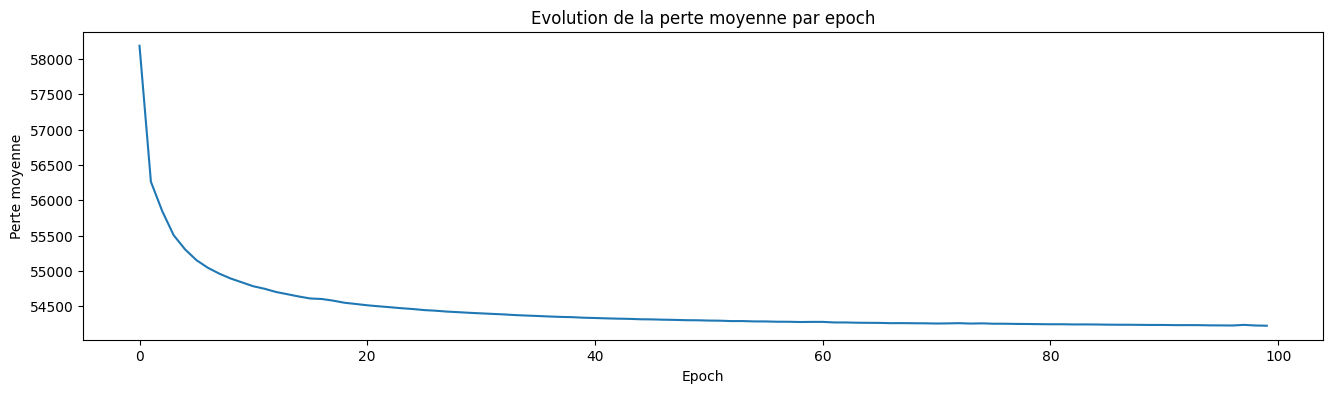

In [18]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(100), losses)
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.show()

In [19]:
pred_train = [ae.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]
pred_test = [ae.forward(testset[i][0].to(torch.device("cuda"))) for i in range(11)]

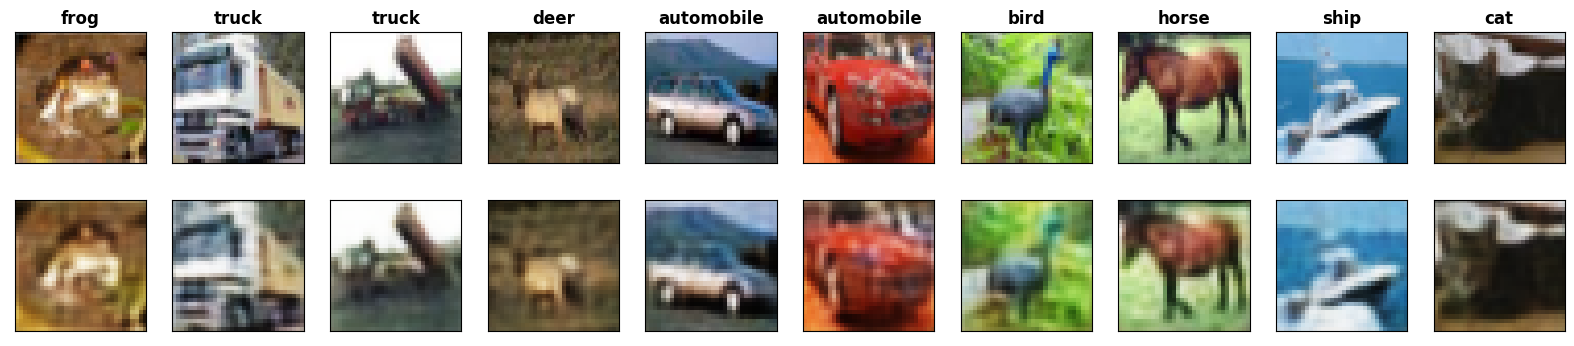

In [20]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(trainset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(pred_train[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

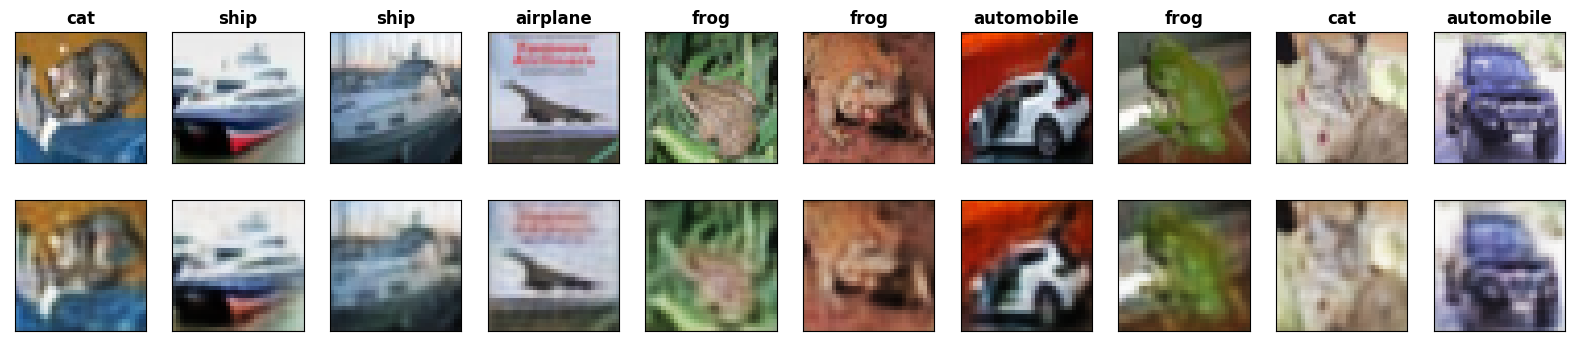

In [21]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(testset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[testset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(pred_test[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Images reconstruites sont plutôt fidèles -> fait apparaître de manière évidente le flou introduit par la méthode stochastique des VAE <br>
Comparaison des images reconstuites (haut VAE, bas autoencodeur standard)

In [22]:
ae_train = [ae.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]
vae_train = [vae.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]

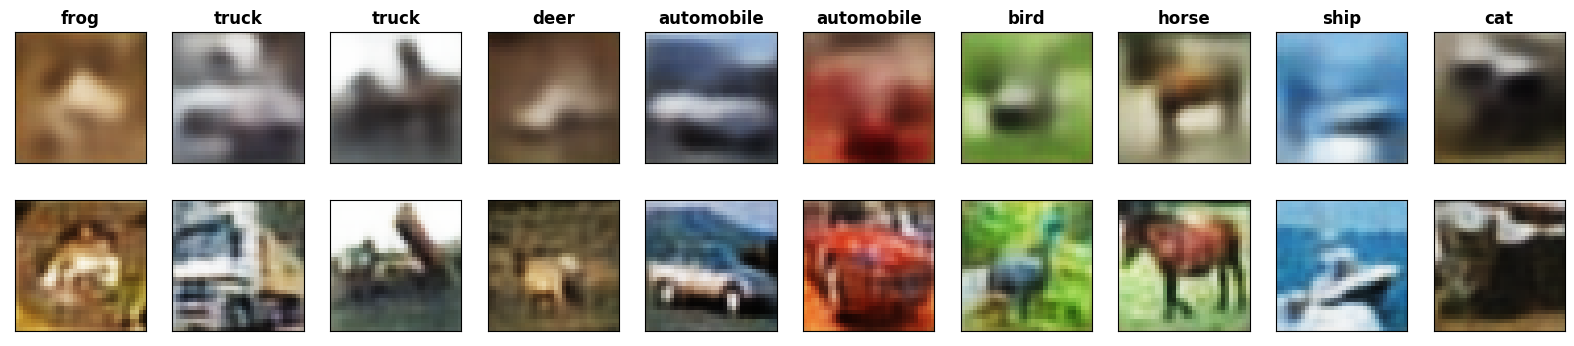

In [23]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(vae_train[i][0].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(ae_train[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
torch.save({'epoch': 100, 'model_state_dict': ae.state_dict(),
            'optimizer_state_dict': optim_ae.state_dict()}, "models/autoencoder_cifar10.pt")
torch.save({'epoch': 100, 'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optim_vae.state_dict()}, "models/vae_cifar10.pt")

In [ ]:
# # Load model
# model = VAE().to(torch.device("cuda"))
# checkpoint = torch.load("models/vae_cifar10.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# model_train = [model.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]

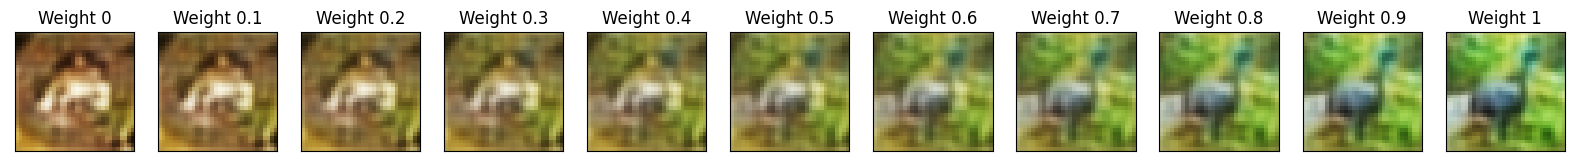

In [25]:
frog_embedding = ae.encode(trainset[0][0].to(torch.device("cuda")))
bird_embedding = ae.encode(trainset[6][0].to(torch.device("cuda")))
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * frog_embedding + w * bird_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(ae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

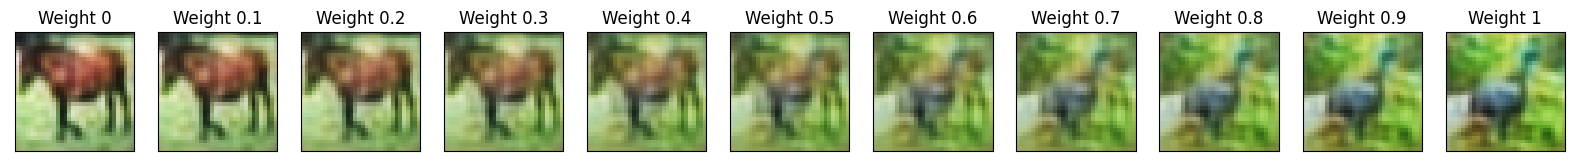

In [27]:
horse_embedding = ae.encode(trainset[7][0].to(torch.device("cuda")))
bird_embedding = ae.encode(trainset[6][0].to(torch.device("cuda")))
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * horse_embedding + w * bird_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(ae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

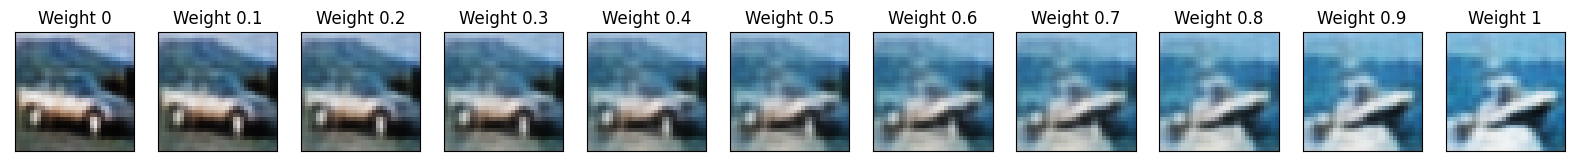

In [31]:
auto_embedding = ae.encode(trainset[4][0].to(torch.device("cuda")))
ship_embedding = ae.encode(trainset[8][0].to(torch.device("cuda")))
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * auto_embedding + w * ship_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(ae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

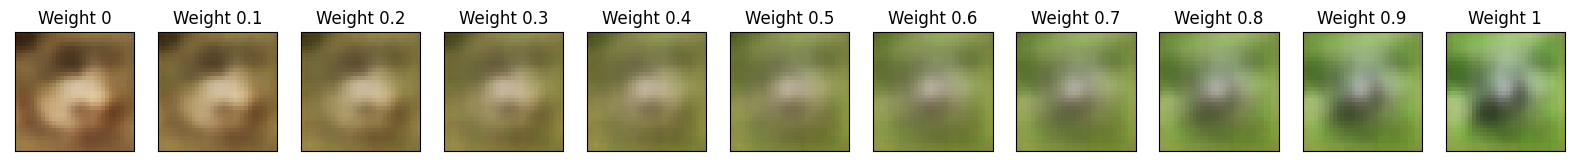

In [26]:
mu_frog, logvar_frog = vae.encode(trainset[0][0].to(torch.device("cuda")))
frog_embedding = vae.sample(mu_frog, logvar_frog)
mu_bird, logvar_bird = vae.encode(trainset[6][0].to(torch.device("cuda")))
bird_embedding = vae.sample(mu_bird, logvar_bird)
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * frog_embedding + w * bird_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(vae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

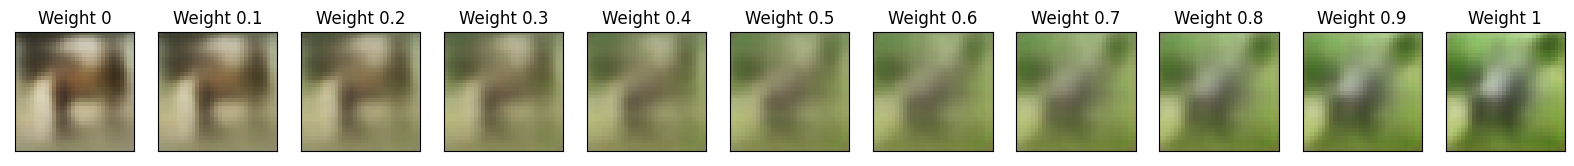

In [30]:
mu_horse, logvar_horse = vae.encode(trainset[7][0].to(torch.device("cuda")))
horse_embedding = vae.sample(mu_horse, logvar_horse)
mu_bird, logvar_bird = vae.encode(trainset[6][0].to(torch.device("cuda")))
bird_embedding = vae.sample(mu_bird, logvar_bird)
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * horse_embedding + w * bird_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(vae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

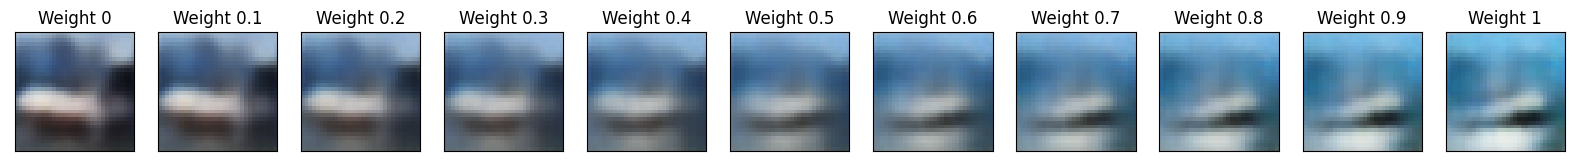

In [32]:
mu_auto, logvar_auto = vae.encode(trainset[4][0].to(torch.device("cuda")))
auto_embedding = vae.sample(mu_auto, logvar_auto)
mu_ship, logvar_ship = vae.encode(trainset[8][0].to(torch.device("cuda")))
ship_embedding = vae.sample(mu_ship, logvar_ship)
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * auto_embedding + w * ship_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(vae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

# GAN standard

## Fréchet Inception Distance (FID)

### Manuel

Calcule la distance de Fréchet entre les embeddings de 2 distributions. Les embeddings des distributions sont créés à partir du modèle Inception v3.

In [6]:
# https://minibatchai.com/metrics/generative-models/2022/07/23/FID.html
inception = torchvision.models.inception_v3(weights='DEFAULT').cuda()
# Hack to get features 
inception.fc = torch.nn.Identity()
inception.eval();

Les images doivent être de dimension 299 $\times$ 299 px. Il faut donc les redimensionner pour créer les embeddings Inception... Plusieurs solutions : padding blanc autour des images, scitkit-image pour scale les images, ... <br>
Je vais resize avec PIL, qui a l'air d'être la seule lib qui le fasse bien d'après cet article : https://github.com/GaParmar/clean-fid -> test avec PIL Bicubic

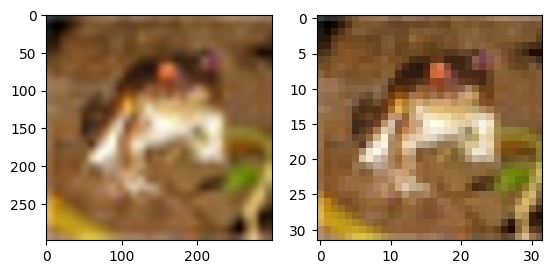

In [9]:
# Test de resize sur 1 image
tensor = []
for channel in trainset[0][0]:
    img = ToPILImage(mode='F')(channel)
    tensor.append(ToTensor()(img.resize((299, 299), resample=Image.BICUBIC)))
tensor3d = torch.clamp(torch.cat(tensor,0), 0, 1)
plt.subplot(1,2,1)
plt.imshow(tensor3d.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(trainset[0][0].permute(1,2,0))
plt.show()

In [7]:
def resize_batch(data):
    resized_batch = []
    for i, _ in enumerate(data):
        tensor = []
        for channel in data[i]:
            img = ToPILImage(mode='F')(channel)
            tensor.append(ToTensor()(img.resize((299, 299), resample=Image.BICUBIC)))
        resized_batch.append(torch.clamp(torch.cat(tensor,0), 0, 1))
    return torch.stack(resized_batch)

In [8]:
def get_moments(data, model):
    with torch.no_grad():
        X_sum = torch.zeros((2048, 1)).to(device)
        XXT_sum = torch.zeros((2048, 2048)).to(device)
        count = 0
        for batch in tqdm(data):
            inp = resize_batch(batch[0])
            pred = model(inp.to(device))
            X_sum += pred.sum(dim=0, keepdim=True).T
            XXT_sum += (pred[:, None] * pred[..., None]).sum(0)
            count += len(inp)
    mean = X_sum / count
    cov = XXT_sum / count - mean @ mean.T

    return mean, cov

In [9]:
mu_ref, cov_ref = get_moments(data_train, inception)

  0%|          | 0/1563 [00:00<?, ?it/s]

In [23]:
torch.norm(mu_ref), torch.norm(cov_ref)

(tensor(17.2548, device='cuda:0'), tensor(21.8451, device='cuda:0'))

Définition de la FID :
$$\text{FID}^2 = \lVert\mu_r - \mu_g\rVert^2_2 + tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{\frac{1}{2}})$$
avec
> $\mu_r$ et $\Sigma_r$ : moyenne et matrice de covariance de l'embeddings via Inception des vraies données <br>
> $\mu_g$ et $\Sigma_g$ : moyenne et matrice de covariance de l'embeddings via Inception des données générées

In [10]:
def compute_fid(mu1, sigma1, mu2, sigma2):
    eigenvals = torch.linalg.eigvals(sigma1 @ sigma2)
    trace_sqrt = eigenvals.real.clamp(min=0).sqrt().sum()
    return ((mu1 - mu2)**2).sum() + sigma1.trace() + sigma2.trace() - 2 * trace_sqrt

Résultats très faibles avec cette méthode (de l'ordre de 10^-3), ce qui semble éloigné de ce qu'on trouve dans les articles

### Avec torchmetrics

Initialisation de l'objet `FrechetInceptionDistance` : 
* On prend toutes les features disponibles pour plus de précision (2048)
* `normalize` à `True` car les pixels ont déjà des valeurs enntre 0 et 1
* `reset_real_features` pour que les features du vrai jeu de données ne soient pas effacées lors d'un reset. Elles sont conservées en mémoire ce qui évite de les recalculer à chaque fois (prend ~3 min pour les recalculer)
* `compute_on_cpu` pour stocker les valeurs en RAM, et non sur la RAM du GPU, ce qui évite de la saturer

In [6]:
fid = FrechetInceptionDistance(feature=2048, normalize=True, reset_real_features=False,
                               compute_on_cpu=True).to(device)

Calcul des features du vrai jeu de données, et stockage de la moyenne et matrice de covariance obtenue pour comparaison avec les données générées à chaque epoch

In [7]:
for data in tqdm(data_train):
    fid.update(data[0].to(device), real=True)

  0%|          | 0/1563 [00:00<?, ?it/s]

## Model

In [11]:
class Generator(torch.nn.Module):
    def __init__(self, z_dim=256):
        super(Generator, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(z_dim, 256, 4, stride=1, padding=0), # [batch, 256, 4, 4]
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # [batch, 128, 8, 8]
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # [batch, 64, 16, 16]
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            torch.nn.Sigmoid()            
        )

        
    def forward(self, z):
        """ Génère un batch d'images à partir d'un batch de bruits initiaux
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batch de bruits initiaux
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        return self.model(z)

In [12]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 4, stride=2, padding=1),           # [batch, 64, 4, 4]
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 4, stride=2, padding=1),          # [batch, 128, 2, 2]
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, 4, stride=2, padding=1),          # [batch, 256, 1, 1]
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 1, 4, stride=1, padding=0),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        """ Classifie un batch d'images en tant que vraie (1) ou fausse (0)
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch de bruits initiaux
            Output:
                label (tensor torch, dim(batch_size)) : tensor de labels prédits des images (vraies ou fausses)
        """
        return self.model(x).view(-1, 1)

In [27]:
class GAN(torch.nn.Module):
    def __init__(self, z_dim=256):
        super(GAN, self).__init__()
        
        self.z_dim = z_dim
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        
    
    def forward(self, z):
        """ Génère un batch d'images à partir d'un batch de bruits initiaux
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batch de bruits initiaux
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        return self.generator(z)
    
    
    def train_model(self, data, epoch, optim_g, optim_d, fid):
        """ Entraîne le modèle, à partir d'un batch d'images d'entraînement pour le discriminateur
            Label = 1 pour les vraies données, 0 pour les données générées par le Generator
            Args:
                data (dataloader torch, dim(dataset_size x 3x32x32)) : jeu complet d'images initiales (en batchs)
                epoch : nombre d'itérations à réaliser sur le jeu d'entraînement complet
                optim_g : optimiseur pour le générateur
                optim_d : optimiseur pour le discriminateur
                fid : Torchmetrics FID, à mettre à jour à chaque epoch avec les images générées
        """
        losses_true, losses_fake, losses_generator, fid_list = [], [], [], []
        for e in tqdm(range(epoch)):
            train_loss_true, train_loss_fake, train_loss_g = 0, 0, 0
            for batch in data:
                # 1) Entraînement du discriminator : max log(D(x)) + log(1 - D(G(z)))
                #     Entraînement sur les vraies données (label=1)
                x = batch[0].to(torch.device("cuda"))
                batch_size = x.shape[0]
                optim_d.zero_grad()
                label_true = torch.full((batch_size, 1), 1, dtype=x.dtype, device=torch.device("cuda"))
                loss_true = binary_cross_entropy(self.discriminator(x), label_true)
                train_loss_true += loss_true.item()
                loss_true.backward()
                
                #     Entraînement sur les données générées par le générateur (label=0)
                z = torch.randn(batch_size, self.z_dim, 1, 1, device=torch.device("cuda"))
                x_prime = self.generator(z)
                label_fake = torch.full((batch_size, 1), 0, dtype=x.dtype, device=torch.device("cuda"))
                loss_fake = binary_cross_entropy(self.discriminator(x_prime.detach()), label_fake)
                train_loss_fake += loss_fake.item()
                loss_fake.backward()
                optim_d.step()
                
                # 2) Entraînement du generator : max log(D(G(z)))
                optim_g.zero_grad()
                # Les images bien générées sont celles classifiées en 1 par le discriminateur
                loss_generator = binary_cross_entropy(self.discriminator(x_prime), label_true)
                train_loss_g += loss_generator.item()
                loss_generator.backward()
                optim_g.step()
            
            # Reset le calcul des moments pour les images générées
            fid.reset()
            # Génère 500 fois 100 images (50 000 en tout) et update le moment pour les images générées
            for i in range(500):
                noise = torch.randn(100, self.z_dim, 1, 1).to(device)
                generated = self.forward(z).to(device)
                fid.update(generated, real=False)
            fid_list.append(fid.compute().item())
            if fid_list[-1] == np.min(fid_list):
                torch.save({'epoch': e, 'model_state_dict': self.state_dict(),'optim_d_state_dict': optim_g.state_dict(),
                        'optim_g_state_dict': optim_g.state_dict()}, "models/gan_cifar10.pt")
            print(f"{datetime.now().strftime('%H:%M:%S')} : Epoch {e} - Loss Discriminator "
                  f"{(train_loss_true + train_loss_fake)/len(data):.2f} - Loss Generator "
                  f"{train_loss_g/len(data):.2f} - FID {fid_list[-1]:.2f}")
            losses_true.append(train_loss_true/len(data))
            losses_fake.append(train_loss_fake/len(data))
            losses_generator.append(train_loss_g/len(data))
        return losses_true, losses_fake, losses_generator, fid_list

In [28]:
gan = GAN().to(device)
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator, fid_list = gan.train_model(data_train, 200, optim_g, optim_d, fid)

  0%|          | 0/200 [00:00<?, ?it/s]

18:45:23 : Epoch 0 - Loss Discriminator 0.15 - Loss Generator 6.45 - FID 382.46
18:46:13 : Epoch 1 - Loss Discriminator 0.15 - Loss Generator 7.42 - FID 344.89
18:46:59 : Epoch 2 - Loss Discriminator 0.20 - Loss Generator 7.05 - FID 317.78
18:47:45 : Epoch 3 - Loss Discriminator 0.18 - Loss Generator 6.97 - FID 331.38
18:48:32 : Epoch 4 - Loss Discriminator 0.20 - Loss Generator 6.55 - FID 325.68
18:49:18 : Epoch 5 - Loss Discriminator 0.21 - Loss Generator 6.27 - FID 325.01
18:50:04 : Epoch 6 - Loss Discriminator 0.20 - Loss Generator 6.41 - FID 316.87
18:50:50 : Epoch 7 - Loss Discriminator 0.27 - Loss Generator 5.72 - FID 319.23
18:51:37 : Epoch 8 - Loss Discriminator 0.27 - Loss Generator 5.26 - FID 318.23
18:52:24 : Epoch 9 - Loss Discriminator 0.24 - Loss Generator 5.30 - FID 343.42
18:53:10 : Epoch 10 - Loss Discriminator 0.24 - Loss Generator 5.54 - FID 326.34
18:53:57 : Epoch 11 - Loss Discriminator 0.23 - Loss Generator 5.54 - FID 309.67
18:54:43 : Epoch 12 - Loss Discriminat

20:10:23 : Epoch 102 - Loss Discriminator 0.08 - Loss Generator 8.81 - FID 282.78
20:11:11 : Epoch 103 - Loss Discriminator 0.12 - Loss Generator 8.82 - FID 283.78
20:11:59 : Epoch 104 - Loss Discriminator 0.09 - Loss Generator 8.95 - FID 298.05
20:12:46 : Epoch 105 - Loss Discriminator 0.09 - Loss Generator 8.88 - FID 282.86
20:13:34 : Epoch 106 - Loss Discriminator 0.08 - Loss Generator 8.96 - FID 282.22
20:14:21 : Epoch 107 - Loss Discriminator 0.09 - Loss Generator 9.10 - FID 276.53
20:15:09 : Epoch 108 - Loss Discriminator 0.10 - Loss Generator 8.95 - FID 283.20
20:15:56 : Epoch 109 - Loss Discriminator 0.09 - Loss Generator 9.04 - FID 285.70
20:16:44 : Epoch 110 - Loss Discriminator 0.11 - Loss Generator 8.92 - FID 294.09
20:17:32 : Epoch 111 - Loss Discriminator 0.07 - Loss Generator 9.26 - FID 287.41
20:18:19 : Epoch 112 - Loss Discriminator 0.09 - Loss Generator 9.25 - FID 272.97
20:19:07 : Epoch 113 - Loss Discriminator 0.09 - Loss Generator 9.22 - FID 303.14
20:19:55 : Epoch

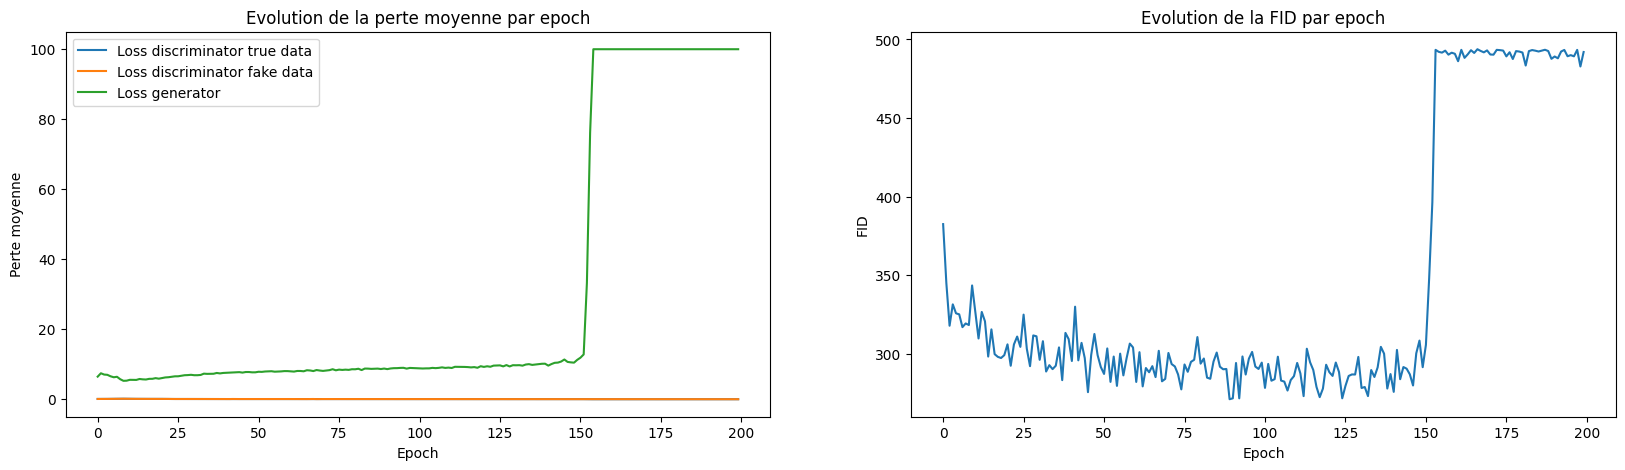

In [29]:
plt.figure(figsize=(20, 5))
ab = np.arange(200)
plt.subplot(1, 2, 1)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(ab, fid_list)
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("Evolution de la FID par epoch")
plt.show()

In [30]:
print(f"Minimum de FID {fid_list[np.argmin(fid_list)]:.2f} atteint à l'epoch {np.argmin(fid_list)}")

Minimum de FID 271.00 atteint à l'epoch 89


In [31]:
model = GAN().eval()
checkpoint = torch.load("models/gan_cifar10.pt")
model.load_state_dict(checkpoint['model_state_dict']);

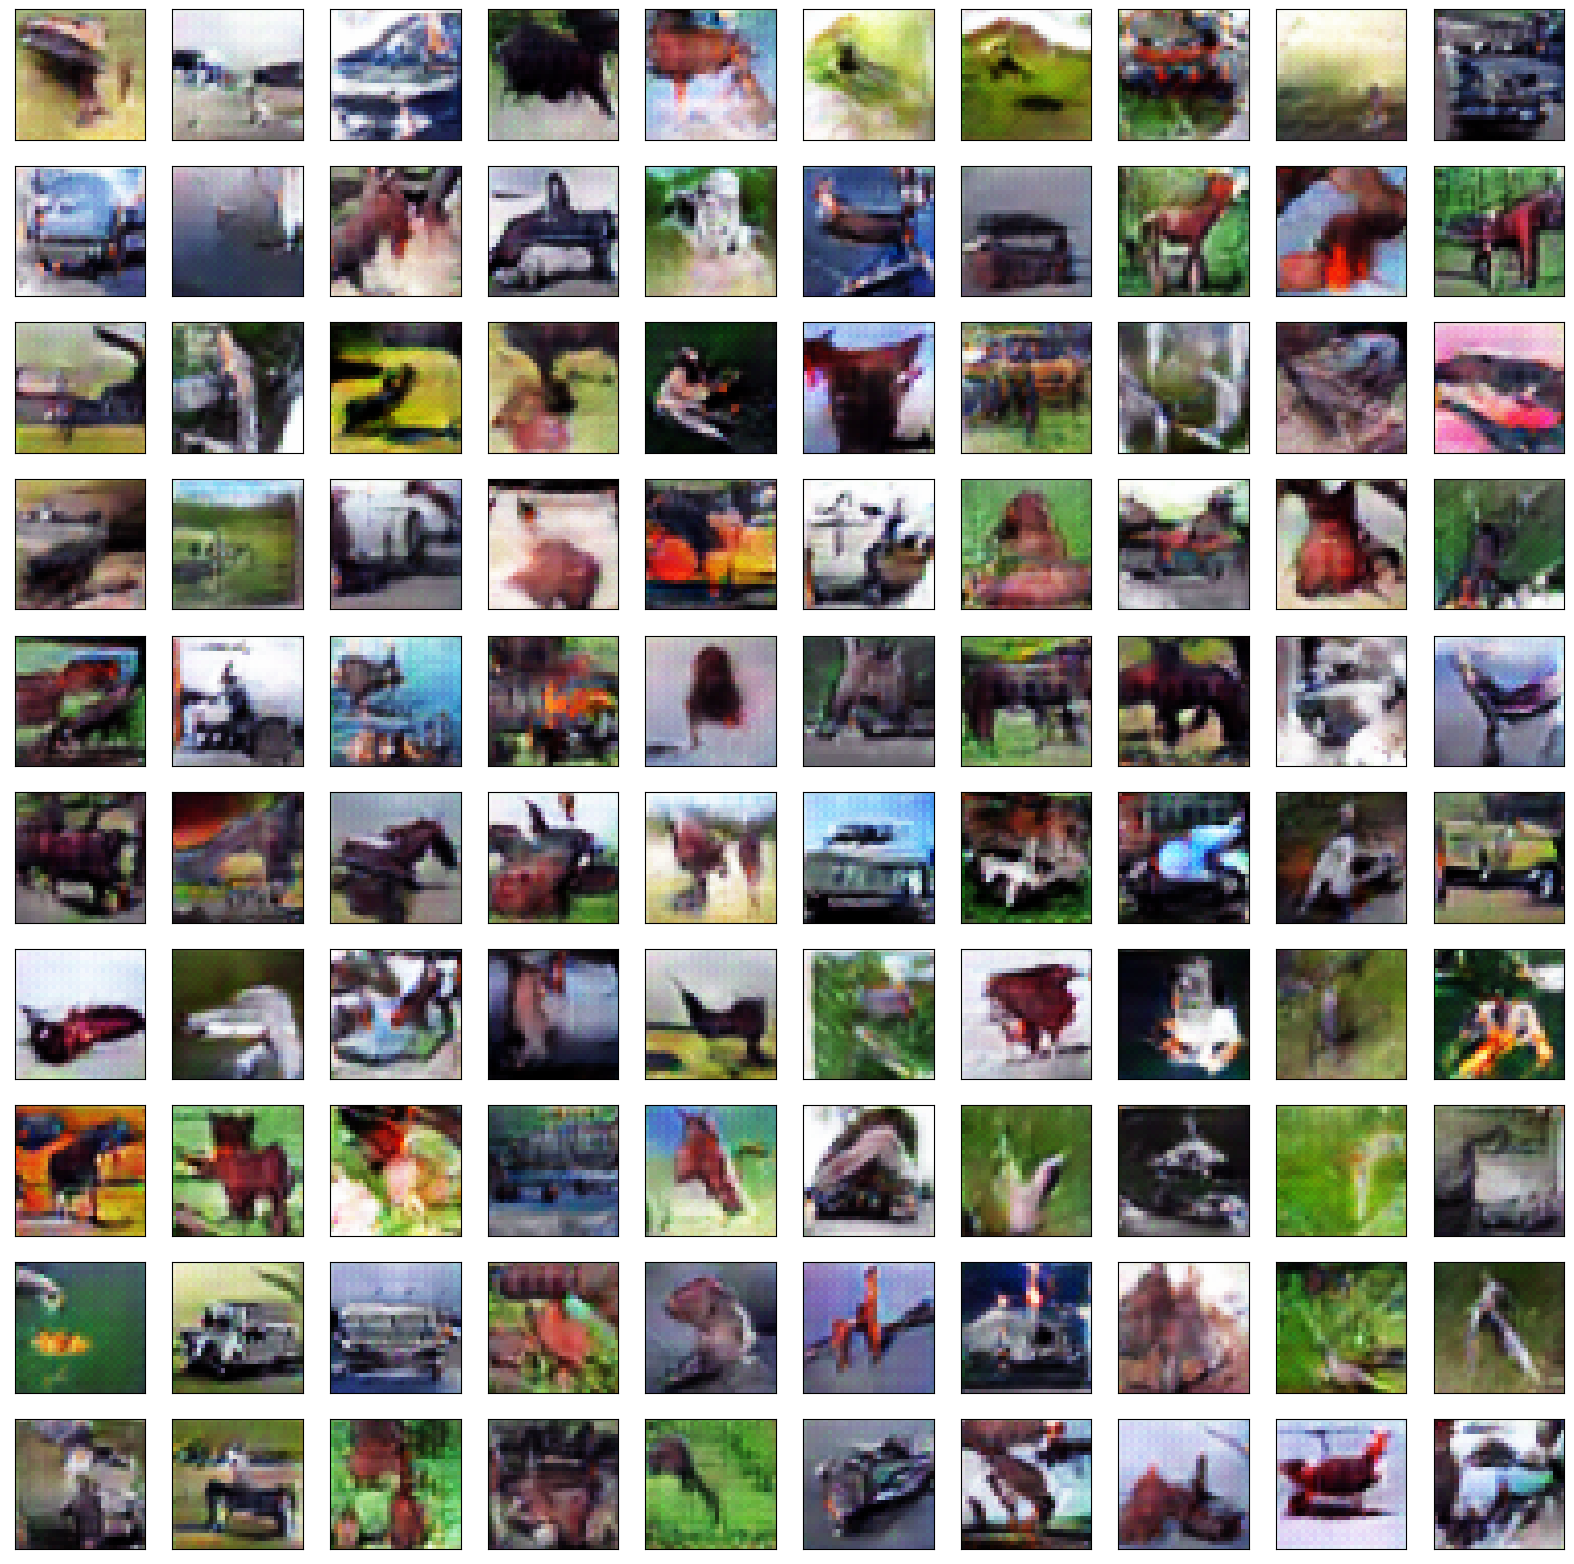

In [32]:
number = 10
plt.figure(figsize=(20, 20))
z = torch.randn(10*number, 256, 1, 1)
generated = model(z)
for i in range(number):
    ax = plt.subplot(10, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 2*number)
    plt.imshow(generated[i+2*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 3*number)
    plt.imshow(generated[i+3*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 4*number)
    plt.imshow(generated[i+4*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 5*number)
    plt.imshow(generated[i+5*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 6*number)
    plt.imshow(generated[i+6*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 7*number)
    plt.imshow(generated[i+7*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 8*number)
    plt.imshow(generated[i+8*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 9*number)
    plt.imshow(generated[i+9*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# WGAN

In [8]:
class Generator(torch.nn.Module):
    def __init__(self, z_dim=256):
        super(Generator, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(z_dim, 256, 4, stride=1, padding=0), # [batch, 256, 4, 4]
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # [batch, 128, 8, 8]
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # [batch, 64, 16, 16]
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            torch.nn.Sigmoid()            
        )

        
    def forward(self, z):
        """ Génère un batch d'images à partir d'un batch de bruits initiaux
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batch de bruits initiaux
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        return self.model(z)

In [9]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 4, stride=2, padding=1),           # [batch, 64, 4, 4]
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 4, stride=2, padding=1),          # [batch, 128, 2, 2]
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, 4, stride=2, padding=1),          # [batch, 256, 1, 1]
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 1, 4, stride=1, padding=0)
        )

    def forward(self, x):
        """ Classifie un batch d'images en tant que vraie (1) ou fausse (0)
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch de bruits initiaux
            Output:
                label (tensor torch, dim(batch_size)) : tensor de labels prédits des images (vraies ou fausses)
        """
        return self.model(x).view(-1, 1)

In [18]:
# https://github.com/Zeleni9/pytorch-wgan
class WGAN(torch.nn.Module):
    def __init__(self, z_dim=256, n_critic=5):
        super(WGAN, self).__init__()
        
        self.z_dim = z_dim
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        self.optim_g = torch.optim.RMSprop(self.generator.parameters(), lr=0.00005)
        self.optim_d = torch.optim.RMSprop(self.discriminator.parameters(), lr=0.00005)
        # Nombre d'entraînement du discriminateur par epoch
        self.n_critic = n_critic
    
    def forward(self, z):
        """ Génère un batch d'images à partir d'un batch de bruits initiaux
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batch de bruits initiaux
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        return self.generator(z)
    
    def train_model(self, data, epoch, fid):
        """ Entraîne le modèle, à partir d'un batch d'images d'entraînement pour le discriminateur
            Label = 1 pour les vraies données, 0 pour les données générées par le Generator
            Args:
                data (dataloader torch, dim(dataset_size x 3x32x32)) : jeu complet d'images initiales (en batchs)
                epoch : nombre d'itérations à réaliser sur le jeu d'entraînement complet
                fid : Torchmetrics FID, à mettre à jour à chaque epoch avec les images générées
        """
        losses_discriminator, losses_generator, fid_list = [], [], []
        for e in tqdm(range(epoch)):
            train_loss_d, train_loss_g = 0, 0
            for i, batch in enumerate(data):
                x = batch[0].to(device)
                batch_size = x.shape[0]

                # 1) Entraînement du discriminator : mean D(x)
                #     Entraînement sur les vraies données (label=1)
                
                # Clamp the weights to a small window such as [-0.01, 0.01] to preserve the Lipschitz continuity
                for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                
                self.optim_d.zero_grad()
                loss_true = self.discriminator(x).mean()
                train_loss_d += loss_true.item()
                loss_true.backward()

                #     Entraînement sur les données générées par le générateur (label=0)
                z = torch.randn(batch_size, self.z_dim, 1, 1, device=device)
                x_prime = self.generator(z).detach()
                loss_fake = -self.discriminator(x_prime).mean()
                train_loss_d += loss_fake.item()
                loss_fake.backward()
                self.optim_d.step()

                # Entraînement du générateur uniquement tous les n_critic batchs
                if i % self.n_critic == self.n_critic - 1 :
                    # 2) Entraînement du generator : max log(D(G(z)))
                    self.optim_g.zero_grad()
                    # Les images bien générées sont celles classifiées en 1 par le discriminateur
                    z = torch.randn(batch_size, self.z_dim, 1, 1, device=device)
                    x_prime = self.generator(z)
                    loss_generator = self.discriminator(x_prime).mean()
                    train_loss_g += loss_generator.item()
                    loss_generator.backward()
                    self.optim_g.step()
            
            # Reset le calcul des moments pour les images générées
            fid.reset()
            # Génère 500 fois 100 images (50 000 en tout) et update le moment pour les images générées
            for i in range(500):
                noise = torch.randn(100, self.z_dim, 1, 1).to(device)
                generated = self.forward(z).to(device)
                fid.update(generated, real=False)
            fid_list.append(fid.compute().item())
            if fid_list[-1] == np.min(fid_list):
                torch.save({'epoch': e, 'model_state_dict': self.state_dict(),'optim_d_state_dict': self.optim_g.state_dict(),
                        'optim_g_state_dict': self.optim_g.state_dict()}, "models/wgan_cifar10.pt")
            print(f"{datetime.now().strftime('%H:%M:%S')} : Epoch {e} - Loss Discriminator "
                  f"{-train_loss_d:.2f} - Loss Generator "
                  f"{train_loss_g:.2f} - FID {fid_list[-1]:.2f}")
            losses_discriminator.append(train_loss_d/len(data))
            losses_generator.append(train_loss_g/(len(data)//self.n_critic))
        return losses_discriminator, losses_generator, fid_list

In [19]:
wgan = WGAN().to(device)
losses_discriminator, losses_generator, fid_list = wgan.train_model(data_train, 200, fid)

  0%|          | 0/200 [00:00<?, ?it/s]

16:04:30 : Epoch 0 - Loss Discriminator 553.45 - Loss Generator 49.20 - FID 371.96
16:05:14 : Epoch 1 - Loss Discriminator 586.25 - Loss Generator 49.06 - FID 382.94
16:05:56 : Epoch 2 - Loss Discriminator 432.25 - Loss Generator 31.19 - FID 346.45
16:06:38 : Epoch 3 - Loss Discriminator 384.68 - Loss Generator 27.25 - FID 348.06
16:07:20 : Epoch 4 - Loss Discriminator 377.63 - Loss Generator 27.61 - FID 329.04
16:08:02 : Epoch 5 - Loss Discriminator 370.52 - Loss Generator 26.11 - FID 339.44
16:08:44 : Epoch 6 - Loss Discriminator 358.01 - Loss Generator 26.13 - FID 320.70
16:09:26 : Epoch 7 - Loss Discriminator 342.80 - Loss Generator 25.49 - FID 322.38
16:10:08 : Epoch 8 - Loss Discriminator 338.47 - Loss Generator 23.34 - FID 314.63
16:10:50 : Epoch 9 - Loss Discriminator 335.21 - Loss Generator 23.26 - FID 305.32
16:11:31 : Epoch 10 - Loss Discriminator 328.07 - Loss Generator 23.43 - FID 314.68
16:12:14 : Epoch 11 - Loss Discriminator 315.30 - Loss Generator 21.41 - FID 306.87
16

17:13:40 : Epoch 99 - Loss Discriminator 86.17 - Loss Generator -1.94 - FID 294.60
17:14:22 : Epoch 100 - Loss Discriminator 85.24 - Loss Generator -1.87 - FID 305.87
17:15:03 : Epoch 101 - Loss Discriminator 84.57 - Loss Generator -1.57 - FID 291.50
17:15:44 : Epoch 102 - Loss Discriminator 83.46 - Loss Generator -2.50 - FID 284.07
17:16:26 : Epoch 103 - Loss Discriminator 83.27 - Loss Generator -1.96 - FID 301.47
17:17:07 : Epoch 104 - Loss Discriminator 82.25 - Loss Generator -2.52 - FID 270.67
17:17:49 : Epoch 105 - Loss Discriminator 81.88 - Loss Generator -3.86 - FID 263.61
17:18:30 : Epoch 106 - Loss Discriminator 80.75 - Loss Generator -2.81 - FID 279.09
17:19:11 : Epoch 107 - Loss Discriminator 80.39 - Loss Generator -3.81 - FID 282.52
17:19:52 : Epoch 108 - Loss Discriminator 80.04 - Loss Generator -2.57 - FID 276.94
17:20:34 : Epoch 109 - Loss Discriminator 79.39 - Loss Generator -3.51 - FID 278.22
17:21:15 : Epoch 110 - Loss Discriminator 78.50 - Loss Generator -2.34 - FID 

18:21:04 : Epoch 197 - Loss Discriminator 48.25 - Loss Generator -7.20 - FID 275.95
18:21:46 : Epoch 198 - Loss Discriminator 48.25 - Loss Generator -6.12 - FID 285.55
18:22:29 : Epoch 199 - Loss Discriminator 48.19 - Loss Generator -5.82 - FID 290.03


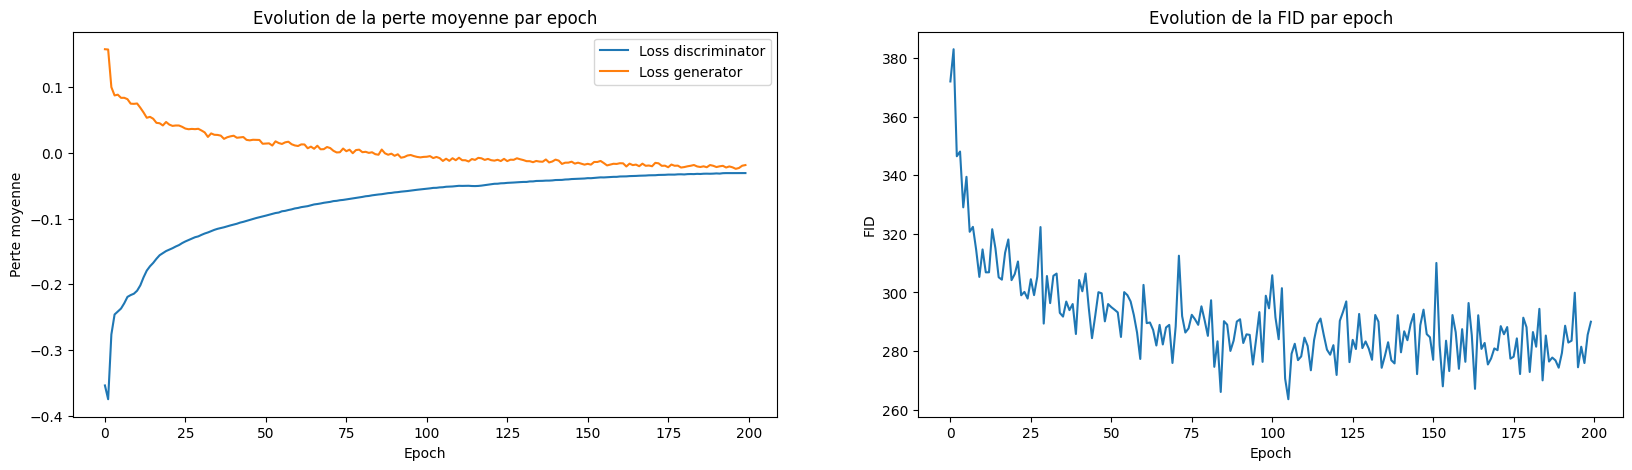

In [20]:
plt.figure(figsize=(20, 5))
ab = np.arange(200)
plt.subplot(1, 2, 1)
plt.plot(ab, losses_discriminator, label="Loss discriminator")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(ab, fid_list)
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("Evolution de la FID par epoch")
plt.show()

In [23]:
print(f"Minimum de FID {fid_list[np.argmin(fid_list)]:.2f} atteint à l'epoch {np.argmin(fid_list)}")

Minimum de FID 263.61 atteint à l'epoch 105


In [21]:
model = WGAN().eval()
checkpoint = torch.load("models/wgan_cifar10.pt")
model.load_state_dict(checkpoint['model_state_dict']);

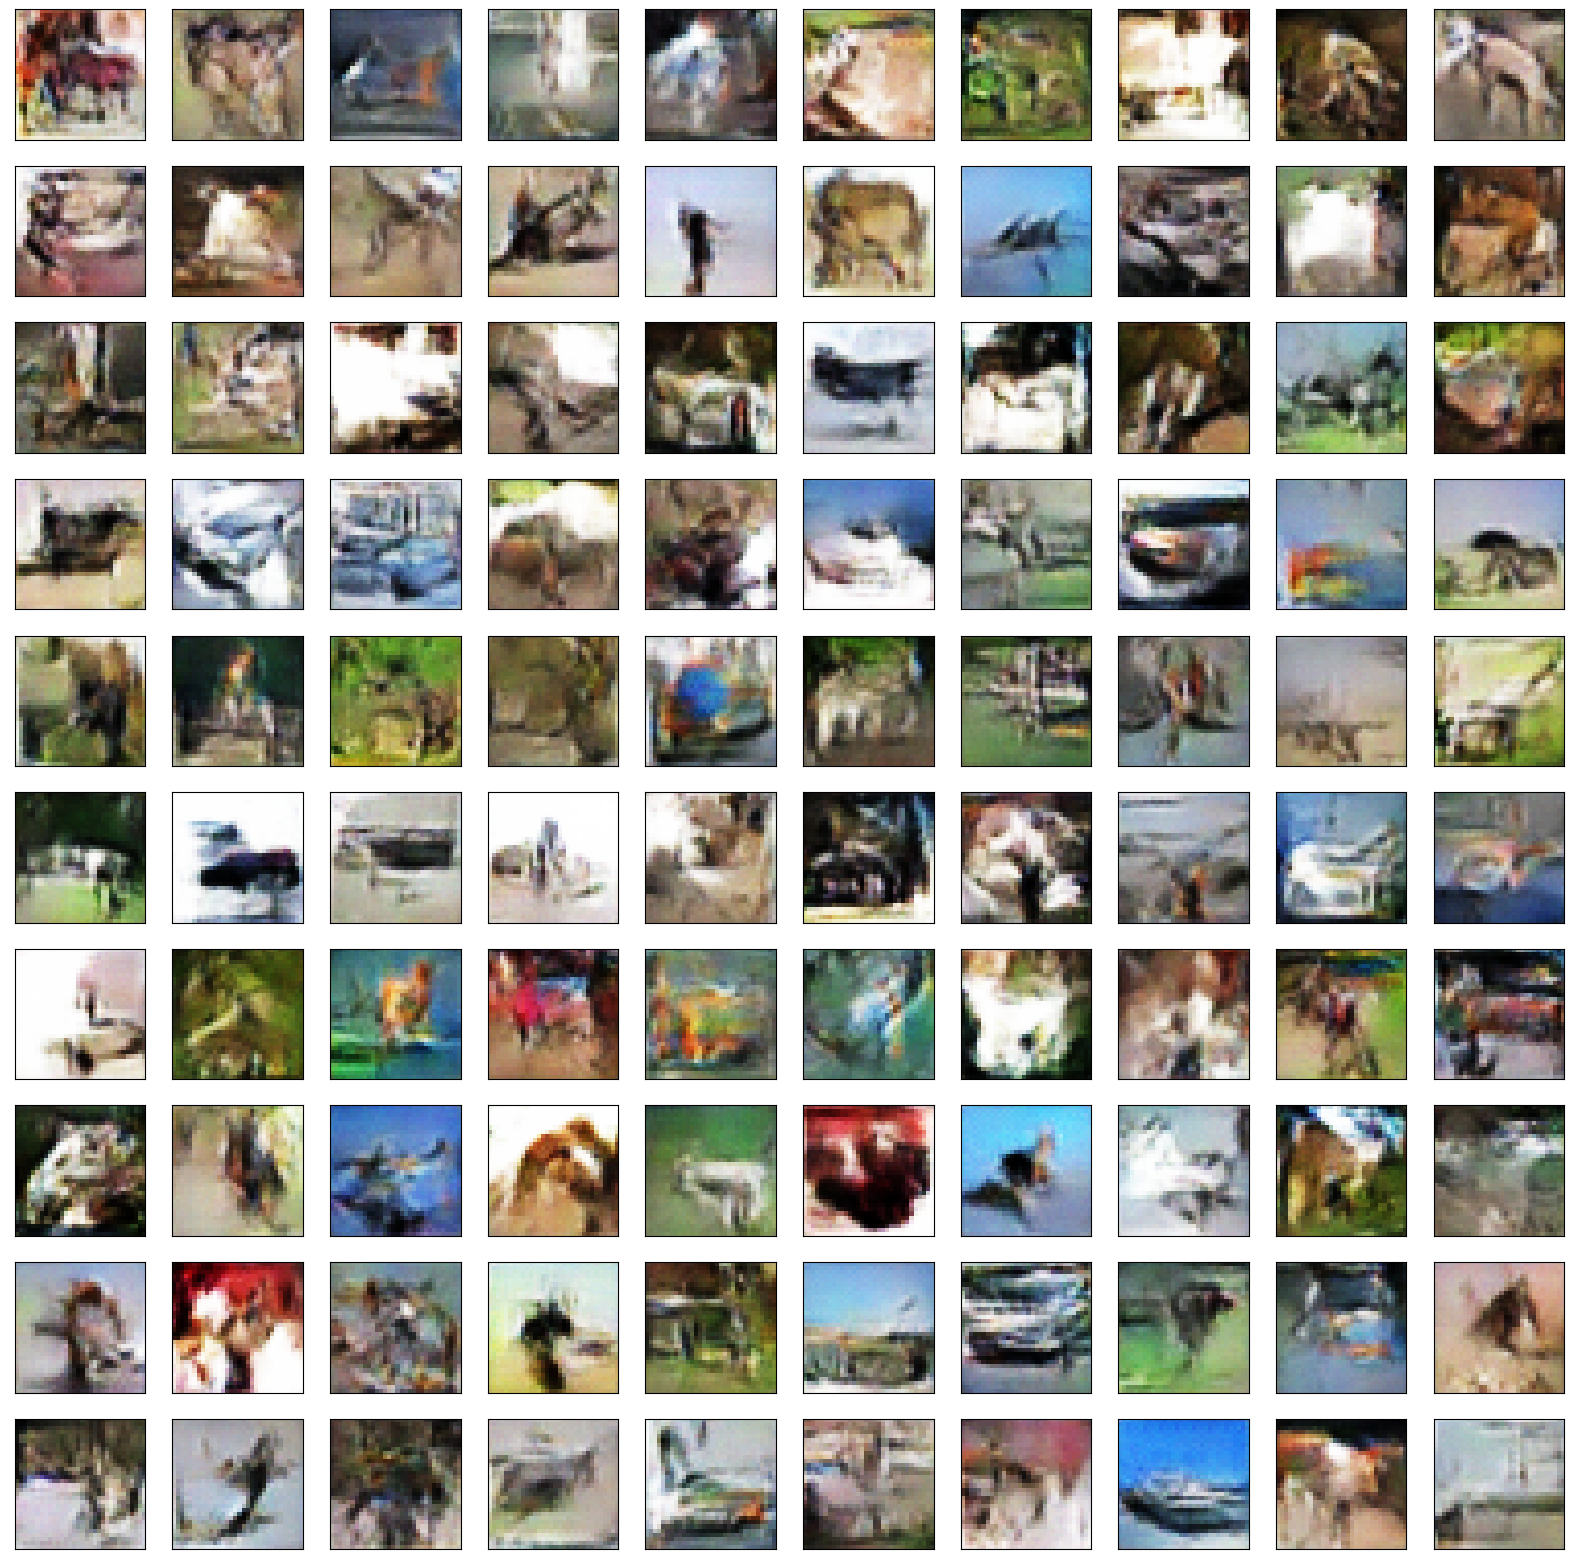

In [22]:
number = 10
plt.figure(figsize=(20, 20))
z = torch.randn(10*number, 256, 1, 1)
generated = model(z)
for i in range(number):
    ax = plt.subplot(10, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 2*number)
    plt.imshow(generated[i+2*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 3*number)
    plt.imshow(generated[i+3*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 4*number)
    plt.imshow(generated[i+4*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 5*number)
    plt.imshow(generated[i+5*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 6*number)
    plt.imshow(generated[i+6*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 7*number)
    plt.imshow(generated[i+7*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 8*number)
    plt.imshow(generated[i+8*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 9*number)
    plt.imshow(generated[i+9*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()